In [2]:
from mpi4py import MPI
import numpy as np
from dolfinx import fem, default_scalar_type, plot, mesh
import ufl
from dolfinx.fem.petsc import LinearProblem
import pyvista  
from helpfunctions import *


[mark_bed_surface] bed facets (id=2): 255
[mark_bed_surface] surface facets (id=1): 253
[mark_bed_surface] unmarked: 0
Min velocity: 0.0, Max velocity: 1.2463936059167033


[mark_bed_surface] bed facets (id=2): 255
[mark_bed_surface] surface facets (id=1): 253
[mark_bed_surface] unmarked: 0


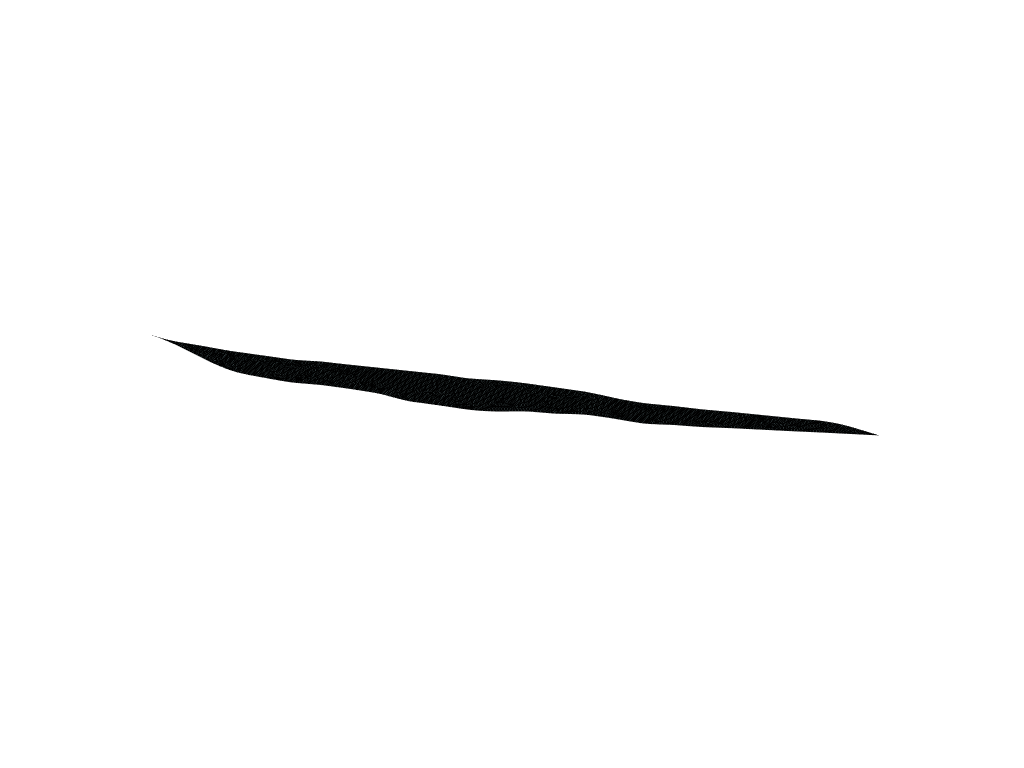

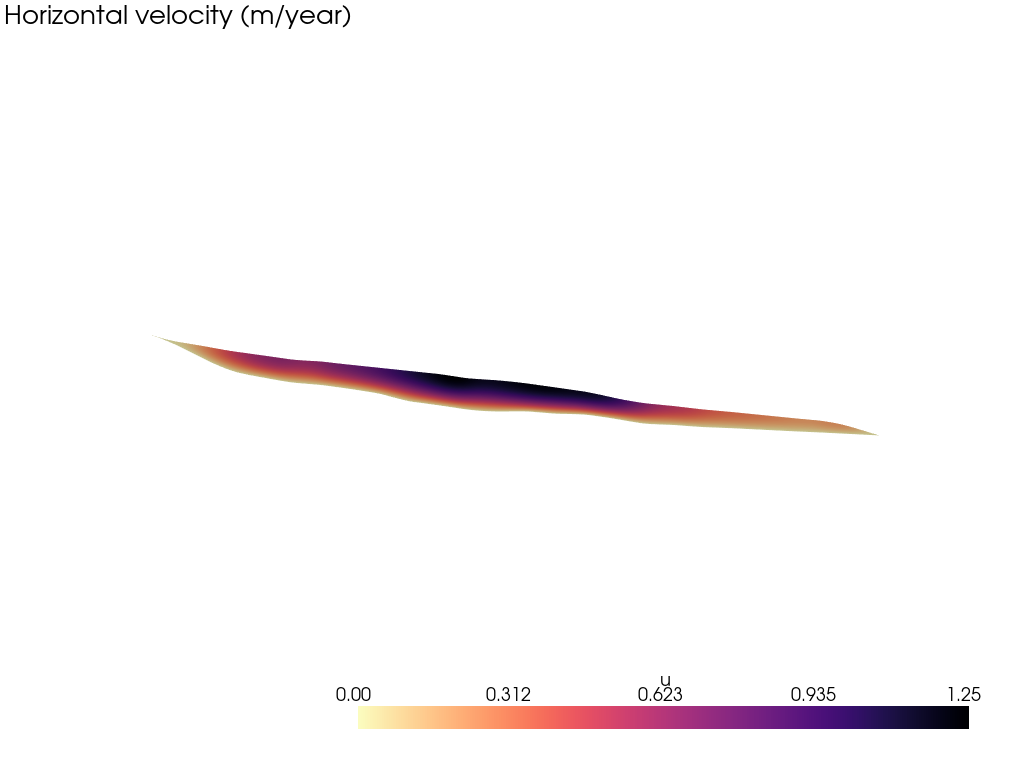

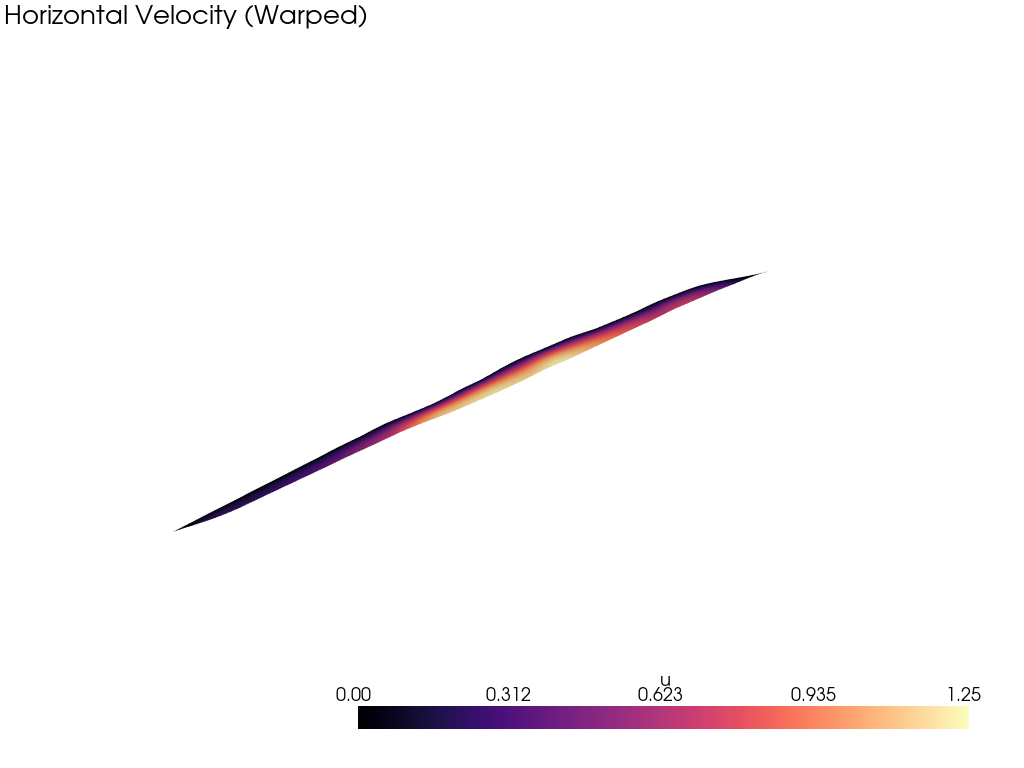

In [17]:
# Glacial Mesh
domain = loadmesh("arolla.xdmf")

# Constants 
seconds_per_year = 31556926.0
rho = fem.Constant(domain, 917.0)
g = fem.Constant(domain, 9.81)
rate_f= fem.Constant(domain, 3.17e-22)#converted to SI units, A: rate factor
epsilon= fem.Constant(domain,1e-15)
eta_c= fem.Constant(domain, 1e15)

# Finite element function space of Langrange polynomials of degree 1
V = fem.functionspace(domain, ("Lagrange", 2))

# Mapping cells to facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundaries = mark_bed_surface(domain)

bed_facets = boundaries.find(2)
bed_dofs = fem.locate_dofs_topological(V, fdim, bed_facets)
#boundary_facets = mesh.exterior_facet_indices(domain.topology)

# Mapping BC: BED(1): Dirichlets homogeneous
uD = fem.Function(V)
uD.interpolate(lambda x: np.zeros_like(x[0])) 
bc = fem.dirichletbc(uD, bed_dofs)

# Trial and Test fucntions 
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Gettting the height
h_surf = get_h(V, boundaries, surface_id=1)
dh_dx= ufl.grad(h_surf)[0]
# problem in weak form
a = ufl.dot(2*eta_c* ufl.grad(u)[0], ufl.grad(v)[0]) * ufl.dx+ ufl.dot(0.5*eta_c* ufl.grad(u) [1], ufl.grad(v)[1]) * ufl.dx
L = -rho*g*dh_dx* v * ufl.dx

# problem: Assembly
problem = LinearProblem(
    a,
    L,
    bcs=[bc],
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    petsc_options_prefix="Poisson",
)

#Solve the problem
uh_sec = problem.solve()
uh = uh_sec.x.array * seconds_per_year

#print(pyvista.global_theme.jupyter_backend)
pyvista.set_jupyter_backend('static')
#pyvista.OFF_SCREEN= False

#domain.topology.create_connectivity(tdim, tdim)
#topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.screenshot("glacier_mesh.jpg")
plotter.show()
plotter.close()

#Visualize: the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.real
u_grid.set_active_scalars("u")

plotter_v = pyvista.Plotter()
plotter_v.add_mesh(u_grid, show_edges=False, cmap="magma_r")
plotter_v.add_text("Horizontal velocity (m/year)", font_size=12)
plotter_v.view_xy()
plotter_v.screenshot("Velocity.jpg")
plotter_v.show()
plotter_v.close()




In [16]:
# --- STEP 2: NON-LINEAR SOLUTION (Question 8 Logic) ---
# We use a Picard loop to solve the non-linear viscosity
u_n = fem.Function(V) # The previous iteration guess
# ... (Picard loop logic goes here) ...
# Let's assume uh_nonlin is the result of that loop
uh_nonlin = uh_nonlin_sec.x.array * seconds_per_year

# --- STEP 3: VISUAL COMPARISON ---
plotter = pyvista.Plotter(shape=(1, 2), window_size=(1800, 600))

# Linear Plot (Constant Viscosity)
plotter.subplot(0, 0)
u_grid.point_data["u"] = uh_linear.real
plotter.add_mesh(u_grid, cmap="magma_r", clim=[0, uh_linear.max()])
plotter.add_text("Linear (Constant Viscosity)", font_size=12)

# Non-Linear Plot (Glen's Flow Law)
plotter.subplot(0, 1)
u_grid.point_data["u_nonlin"] = uh_nonlin.real
plotter.add_mesh(u_grid, scalars="u_nonlin", cmap="magma_r", clim=[0, uh_nonlin.max()])
plotter.add_text("Non-Linear (Glen's Law)", font_size=12)

plotter.show()

# Warped 
warped = u_grid.warp_by_scalar("u", factor=0.5) 

plotter_w = pyvista.Plotter()
plotter_w.add_mesh(warped, show_edges=False, show_scalar_bar=True, cmap="magma")
plotter_w.add_text("Horizontal Velocity (Warped)", font_size=12)
# plotter_w.view_xy() # Usually best to see warped in 3D, so maybe don't use view_xy here
plotter_w.screenshot("Velocity-warped.jpg")
plotter_w.show()
plotter_w.close()


NameError: name 'uh_nonlin_sec' is not defined